![](https://live.staticflickr.com/5009/5277522498_7646c3b586_z.jpg)

# Energy Efficiency

This project aims to study the relationships between physical parameters of buildings and the power required to cool and heat them. The goal is to build machine learning models to predict these energy variables. This topic is important because it is directly related to energy efficiency, which is a critical issue in the current context of energy generation and consumption within a country. The dataset used in this study was constructed by the [Center of Machine Learning and Intelligent Systems](https://cml.ics.uci.edu/) in Irvine, California. It consists of 12 different building shapes simulated in Ecotect. A total of 768 building shapes were generated, each with its own dimensions and estimated heat and cooling load values.

# Dictionary (Columns)
- Heating Load (kW) 
- Cooling Load (kW)
- Relative Compactness
- Surface Area (m²)
- Wall Area (m²)
- Roof Area (m²)
- Overall Height (m)
- Orientation (2:North, 3:East, 4:South, 5:West)
- Glazing Area (% of floor area)
- Glazing Area Distribution ()

# References
- [Kaggle dataset](https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set?rvi=1)
- [Useful informations](https://pt.slideshare.net/NitinAgarwal53/exploratory-data-analysis-for-energy-efficiency)
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/242/energy+efficiency)
- [Introductory Paper](https://www.sciencedirect.com/science/article/abs/pii/S037877881200151X?via%3Dihub)

## 1) Importing Libraries and Loading Data

In [147]:
# Libraries:
import pandas as pd
import numpy as np
from statsmodels.api import qqplot
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, f_regression, RFECV

In [148]:
# Reading dataset:
df = pd.read_csv("data\energy_efficiency_data.csv")

In [149]:
# Plotting some records:
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [150]:
# Informations about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [151]:
num_cols = ["Relative_Compactness", "Surface_Area", 
            "Wall_Area", "Roof_Area", 
            "Overall_Height", "Glazing_Area", 
            "Heating_Load", "Cooling_Load"]

cat_cols = ["Orientation", "Glazing_Area_Distribution"]



df["Relative_Compactness"] = df["Relative_Compactness"].astype(np.float32)
df["Surface_Area"] = df["Surface_Area"].astype(np.float32)
df["Wall_Area"] = df["Wall_Area"].astype(np.float32)
df["Roof_Area"] = df["Roof_Area"].astype(np.float32)
df["Overall_Height"] = df["Overall_Height"].astype(np.float32)
df["Glazing_Area"] = df["Glazing_Area"].astype(np.float32)
df["Heating_Load"] = df["Heating_Load"].astype(np.float32)
df["Cooling_Load"] = df["Cooling_Load"].astype(np.float32)
df["Orientation"] = df["Orientation"].astype("category")
df["Glazing_Area_Distribution"] = df["Glazing_Area_Distribution"].astype("category")

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Relative_Compactness       768 non-null    float32 
 1   Surface_Area               768 non-null    float32 
 2   Wall_Area                  768 non-null    float32 
 3   Roof_Area                  768 non-null    float32 
 4   Overall_Height             768 non-null    float32 
 5   Orientation                768 non-null    category
 6   Glazing_Area               768 non-null    float32 
 7   Glazing_Area_Distribution  768 non-null    category
 8   Heating_Load               768 non-null    float32 
 9   Cooling_Load               768 non-null    float32 
dtypes: category(2), float32(8)
memory usage: 26.0 KB


As we can see above, there are no null values.

## 2) Exploratory Data Analysis

### 2.1) Descriptive Statistics and Distributions

Let's see some descriptive statistics of the variables

In [153]:
df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Glazing_Area,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.00000,768.000000,768.00000,768.000000,768.000000,768.000000
mean,0.764167,671.708313,318.50000,176.604172,5.25000,0.234375,22.307199,24.587761
std,0.105777,88.086113,43.62648,45.165951,1.75114,0.133221,10.090196,9.513306
min,0.620000,514.500000,245.00000,110.250000,3.50000,0.000000,6.010000,10.900000
25%,0.682500,606.375000,294.00000,140.875000,3.50000,0.100000,12.992500,15.620000
50%,0.750000,673.750000,318.50000,183.750000,5.25000,0.250000,18.950000,22.080000
75%,0.830000,741.125000,343.00000,220.500000,7.00000,0.400000,31.667500,33.132501
max,0.980000,808.500000,416.50000,220.500000,7.00000,0.400000,43.099998,48.029999


In [154]:
class Subplots:
    
    def __init__(self, dataframe, n_cols=4) -> None:
        self.dataframe = dataframe
        self.colunas_tamanho = len(dataframe.columns)
        self.n_cols = n_cols
        self.n_rows = (self.colunas_tamanho // 4) + 1
        
        
    def histogram(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    sns.histplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], kde=True)    
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1

    
    def boxplot(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    sns.boxplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col])    
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1
    
    def qq_plot(self):
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    qqplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], line="s")  
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1

In [155]:
subp = Subplots(df[num_cols])

#### 2.1.1) Histograms

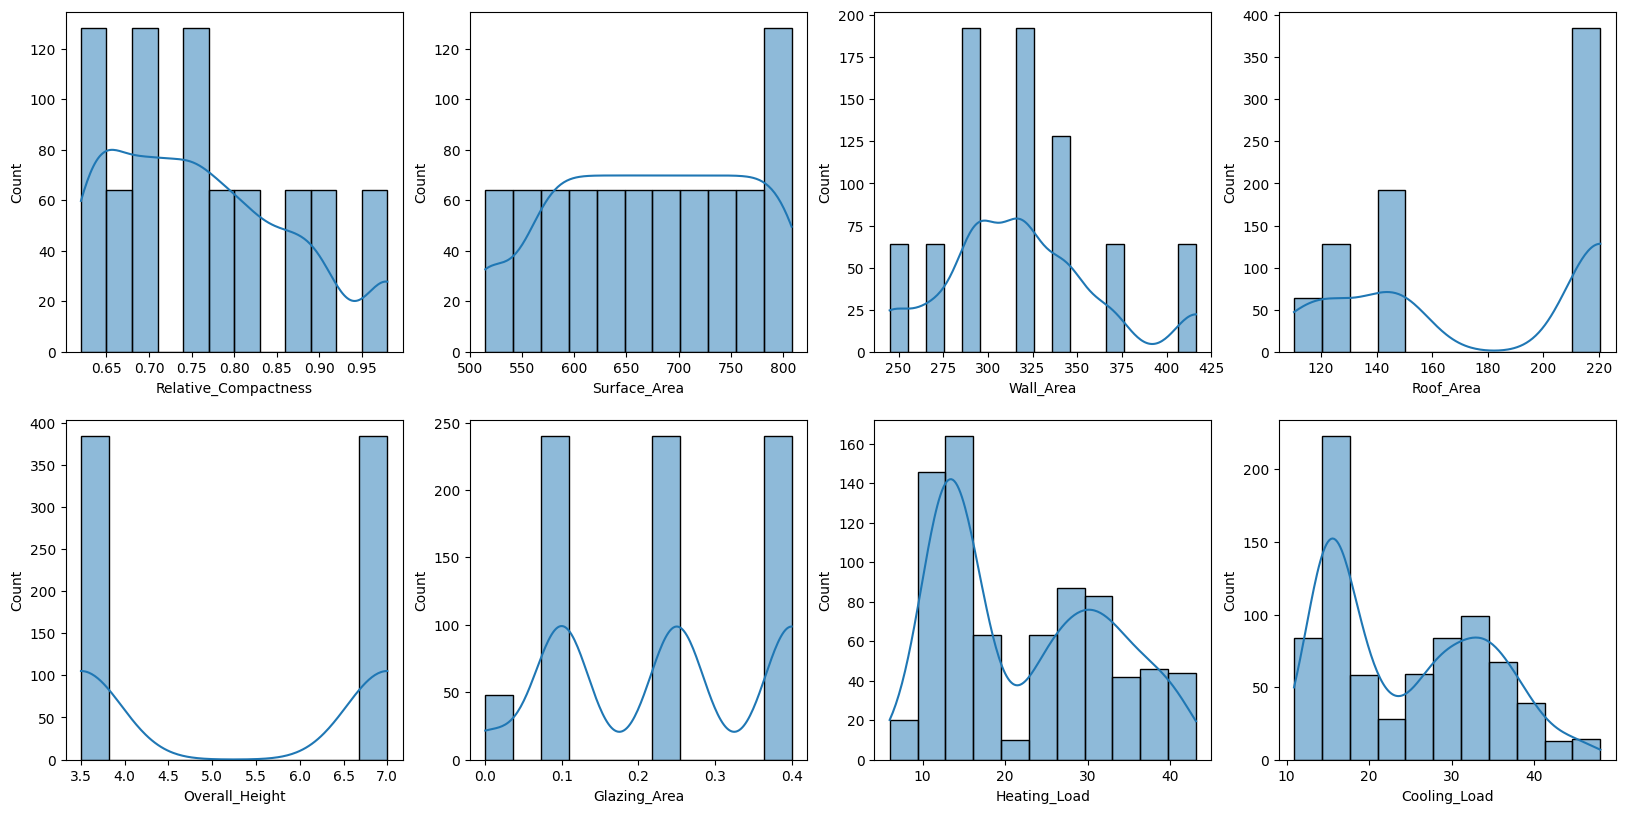

In [156]:
# Histogram plots
subp.histogram()

#### 2.1.2) Boxplots

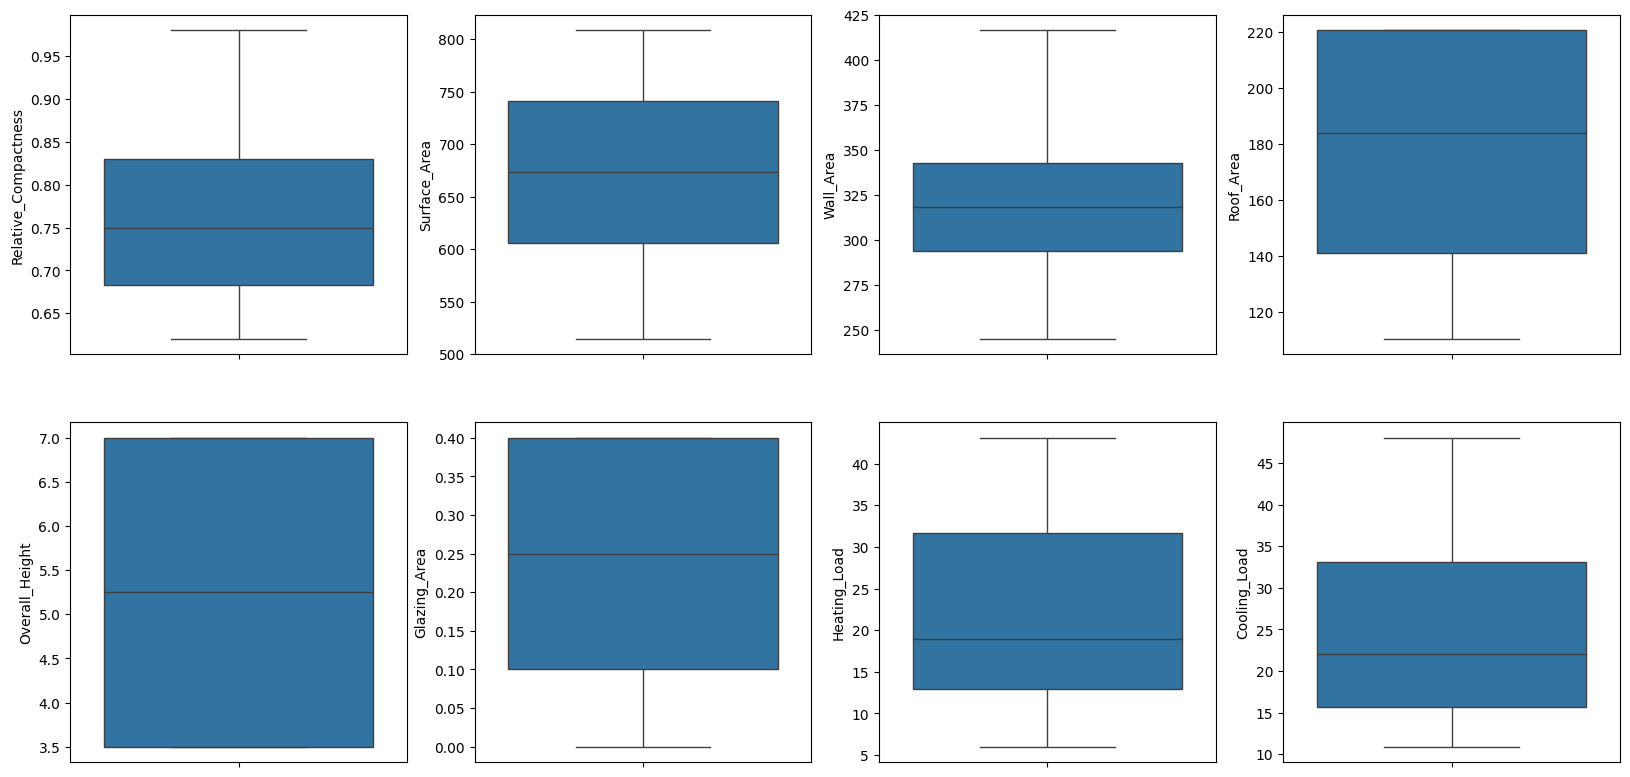

In [157]:
# Boxplots
subp.boxplot()

### 2.2) Correlations

In [158]:
# Function to plot heatmap of correlations:

def plot_correlation(dataframe):
    correlations=dataframe.corr()

    mask =  np.zeros_like(correlations)
    mask[np.triu_indices_from(mask)] = True


    plt.figure(figsize=(27, 10))
    sns.heatmap(correlations, annot=True, mask=mask, cmap="crest");

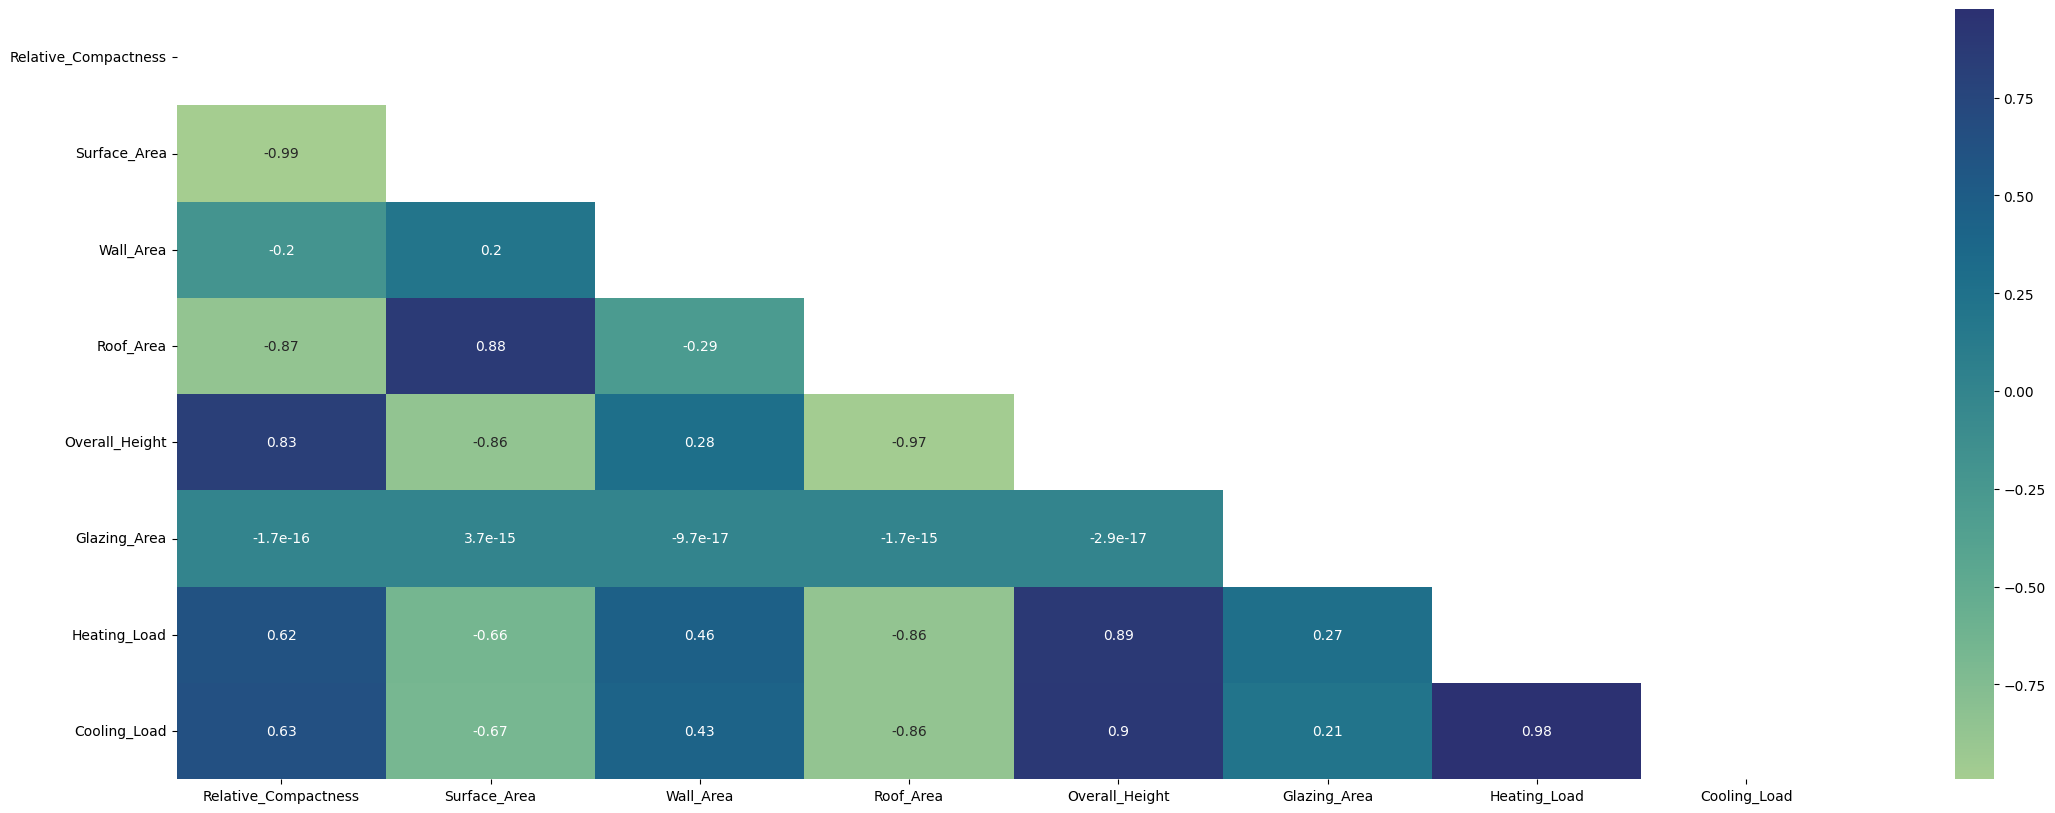

In [159]:
# Pearson's Correlation:
plot_correlation(df[num_cols])

In [160]:
# Chi-squared:
def ch2_func(features, target):
    cat_columns = features.columns
    statistics = []
    p_values = []
    
    for feature in cat_columns:
        # Creating a contingency table:
        df_contingency = pd.crosstab(features[feature], target)

        # Chi squared:
        statistic, p_value, dof, expected = chi2_contingency(df_contingency)
    
        statistics.append(statistic)
        p_values.append(p_value)
        
    dicionario = dict(Chi_Squared=statistics, P_value=p_values)
    df_ch = pd.DataFrame(index=cat_columns, data=dicionario)
    return df_ch

In [161]:
corr = ch2_func(df[cat_cols], df["Heating_Load"])
corr

,Chi_Squared,P_value
Orientation,1765.866667,0.422975
Glazing_Area_Distribution,3108.977778,0.009005


### 2.3) Exploring relations between Variables

#### 2.3.1) Relative Compactness and Cooling/Heating loads 

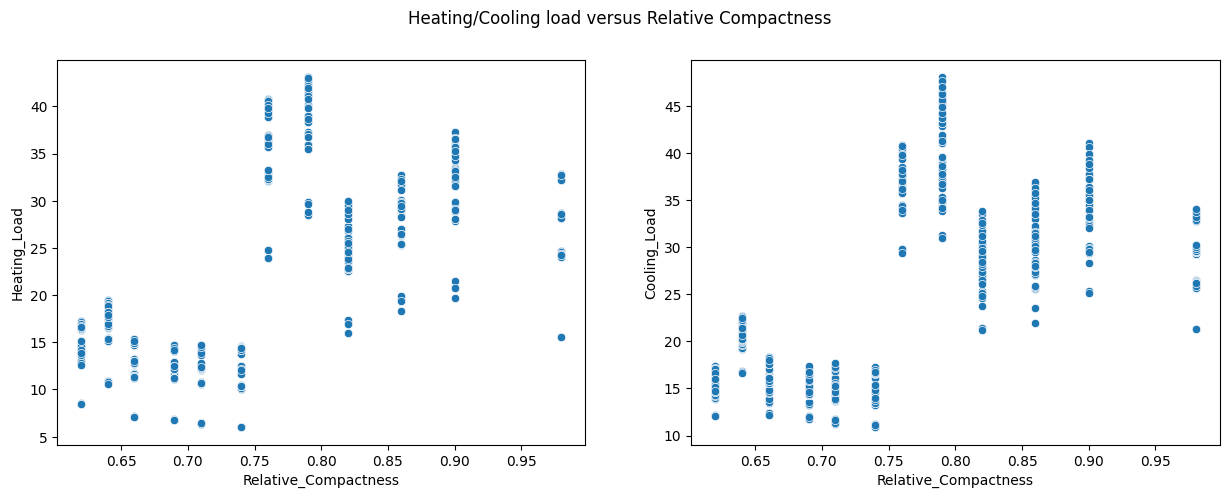

In [162]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Relative Compactness")
sns.scatterplot(x=df["Relative_Compactness"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Relative_Compactness"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.2) Surface Area and Cooling/Heating loads 

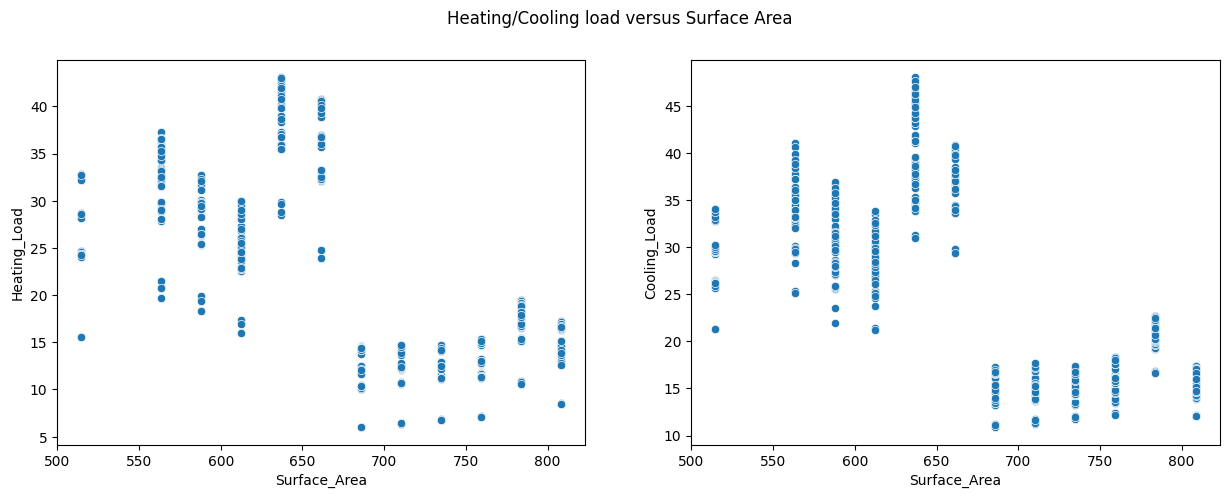

In [163]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Surface Area")
sns.scatterplot(x=df["Surface_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Surface_Area"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.3) Wall Area and Cooling/Heating loads 

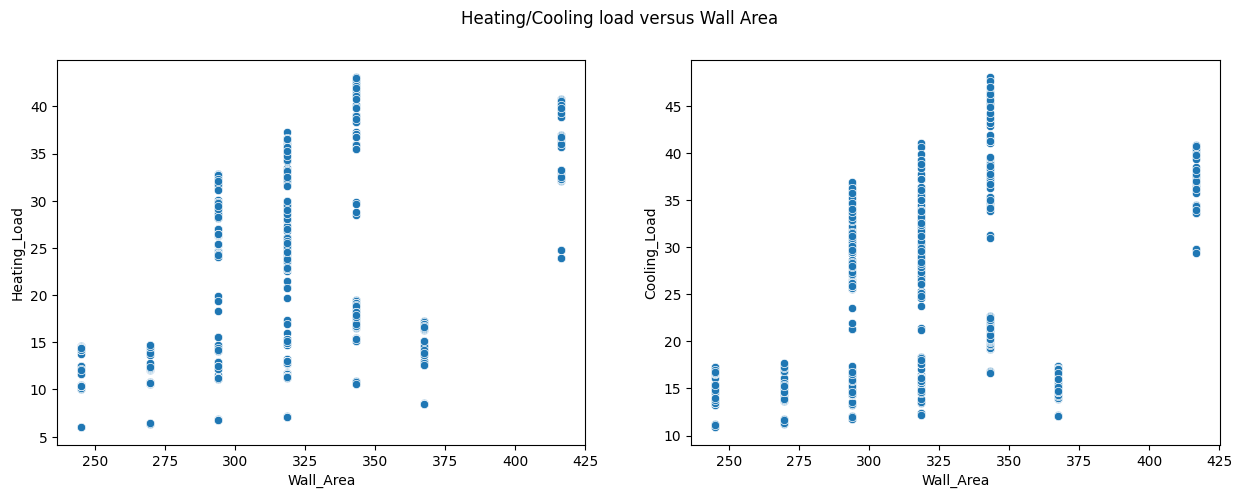

In [164]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Wall Area")
sns.scatterplot(x=df["Wall_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Wall_Area"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.4) Roof Area and Cooling/Heating loads 

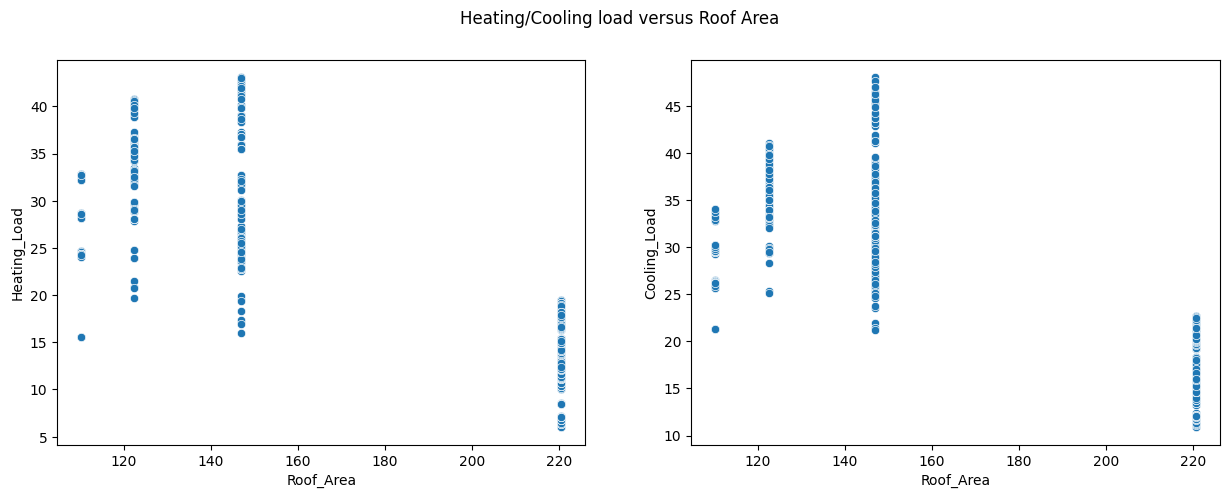

In [165]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Roof Area")
sns.scatterplot(x=df["Roof_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Roof_Area"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.5) Overall Height and Cooling/Heating loads 

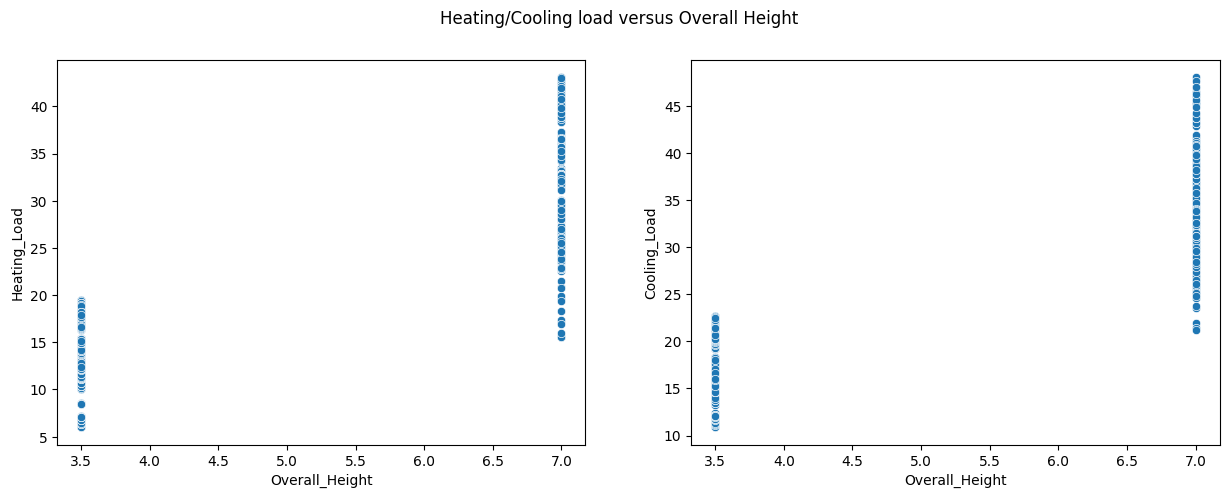

In [166]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Overall Height")
sns.scatterplot(x=df["Overall_Height"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Overall_Height"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.6) Orientation and Cooling/Heating loads

In [167]:
def map_orientation(row):
    if row == 2:
        return "North"
    elif row == 3:
        return "East"
    elif row == 4:
        return "South"
    else:
        return "West"

In [168]:
data_orientation_mapped = df["Orientation"].apply(map_orientation)
new_dataframe = df[["Heating_Load", "Cooling_Load"]].copy()
new_dataframe["Orientation_mapped"] = data_orientation_mapped
grouped = new_dataframe.groupby("Orientation_mapped", observed=False).mean().reset_index()

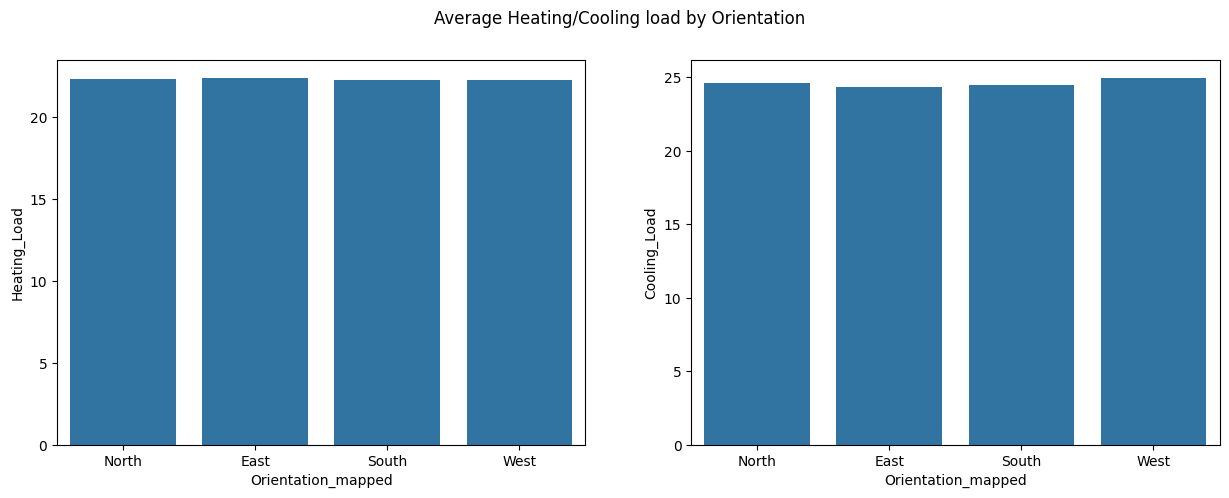

In [169]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Average Heating/Cooling load by Orientation")
sns.barplot(x=grouped["Orientation_mapped"], y=grouped["Heating_Load"], ax=ax[0])
sns.barplot(x=grouped["Orientation_mapped"], y=grouped["Cooling_Load"], ax=ax[1]);

#### 2.3.7) Glazing Area and Cooling/Heating loads

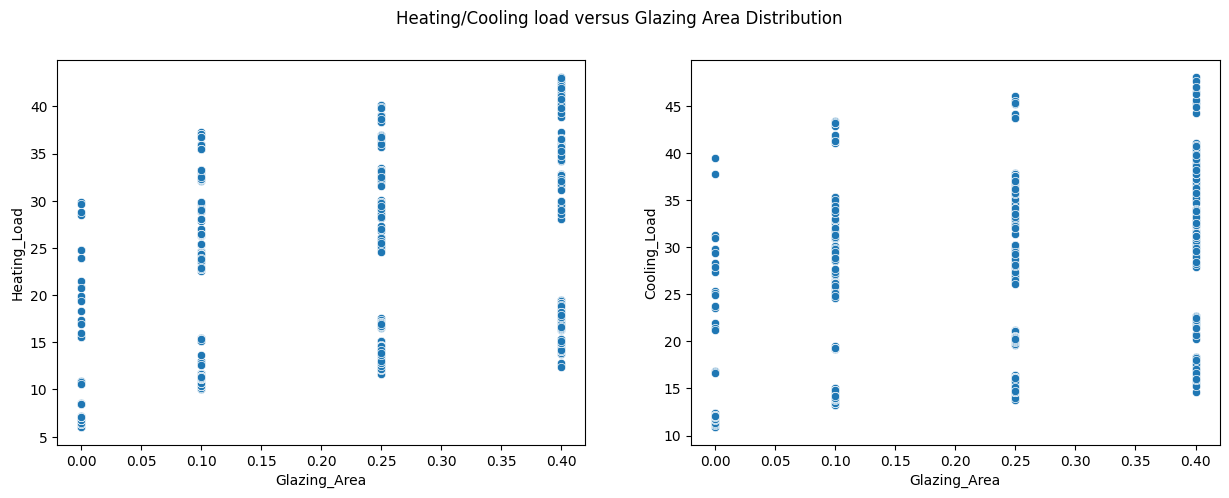

In [170]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Glazing Area Distribution")
sns.scatterplot(x=df["Glazing_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Glazing_Area"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.8) Glazing Area Distribution and Cooling/Heating loads

In [171]:
df["Glazing_Area_Distribution"].value_counts()

Glazing_Area_Distribution
1    144
2    144
3    144
4    144
5    144
0     48
Name: count, dtype: int64

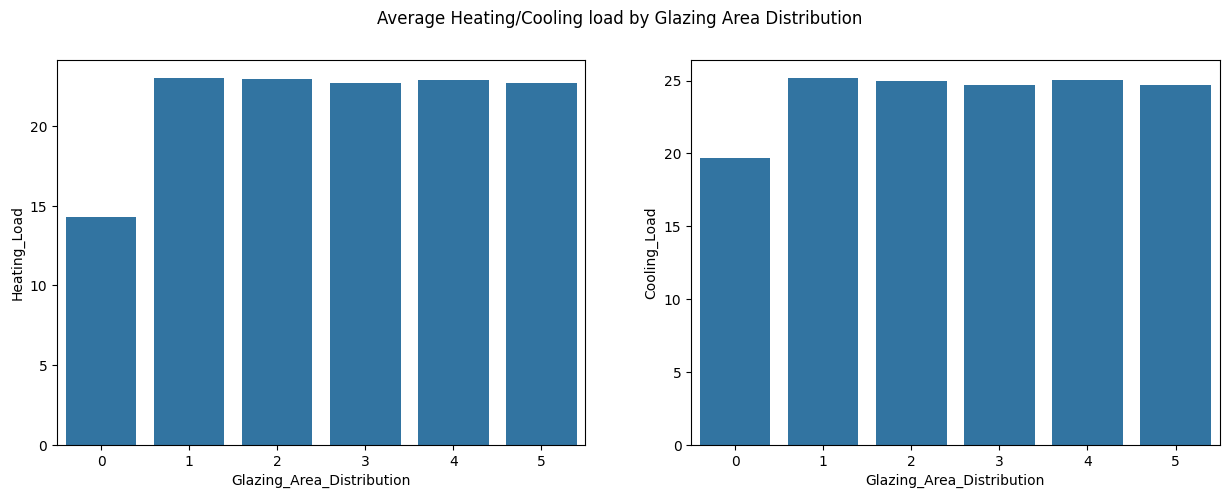

In [172]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Average Heating/Cooling load by Glazing Area Distribution")
df_grouped_glazing_area_dist = df.groupby("Glazing_Area_Distribution", observed=False)[["Heating_Load", "Cooling_Load"]].mean().reset_index()
sns.barplot(x=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], y=df_grouped_glazing_area_dist["Heating_Load"], ax=ax[0])
sns.barplot(x=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], y=df_grouped_glazing_area_dist["Cooling_Load"], ax=ax[1]);

## 3) Preprocessing

In [173]:
seed = 42
features = df.drop(columns=["Heating_Load", "Cooling_Load"])
targets = df[["Heating_Load", "Cooling_Load"]]

In [174]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, shuffle=True, random_state=seed)

### 3.1) Categorical Transformation

In [175]:
one_hot = OneHotEncoder(sparse_output=False, drop="first", dtype=np.int8)
cat_train_transf = one_hot.fit_transform(X_train[cat_cols])
cat_test_transf = one_hot.transform(X_test[cat_cols])

In [176]:
X_train.drop(columns=cat_cols, inplace=True)
X_train[one_hot.get_feature_names_out()] = cat_train_transf
X_test[one_hot.get_feature_names_out()] = cat_test_transf

In [177]:
X_train.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Glazing_Area,Orientation_3,Orientation_4,Orientation_5,Glazing_Area_Distribution_1,Glazing_Area_Distribution_2,Glazing_Area_Distribution_3,Glazing_Area_Distribution_4,Glazing_Area_Distribution_5
334,0.62,808.5,367.5,220.5,3.5,0.25,0,1,0,1,0,0,0,0
139,0.64,784.0,343.0,220.5,3.5,0.10,0,0,1,0,1,0,0,0
485,0.90,563.5,318.5,122.5,7.0,0.25,1,0,0,0,0,0,0,1
547,0.79,637.0,343.0,147.0,7.0,0.40,0,0,1,1,0,0,0,0
18,0.79,637.0,343.0,147.0,7.0,0.00,0,1,0,0,0,0,0,0


### 3.2) Feature Selection

In [178]:
# Class that put together many feature selection techniques:

class feature_selector:
    seed = 42
    def __init__(self, X, y) -> None:
        self.X_train = X
        self.y_train = y
    
    def  randomforestR_imp(self) -> None:
        model = RandomForestRegressor(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        # Plotting RandomForest Regression Importance:
        plt.title("RandomForest Importance")
        plt.xlabel("Importance")
        sns.barplot(x=series.values, y=series.index)
        

    def xgbR_imp(self) -> None:
        model = XGBRegressor(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        # Plotting XGboost Regression Feature Importance:
        plt.title("XGBoost Feature Importance")
        plt.xlabel("Importance")
        sns.barplot(y=series.index, x=series.values)

    # Univariate feature selection:
    def univariate(self, statistic, n="all") -> None:
        selector = SelectKBest(score_func=statistic, k=n)
        selector.fit(self.X_train, self.y_train)
        
        series = pd.Series(index=selector.feature_names_in_, data=selector.scores_).\
            sort_values(ascending=False)
        plt.title("F-Regression Filtering")
        plt.xlabel("F-score")
        sns.barplot(y=series.index, x=series.values)

        return selector
    
    # Wrapper method for feature selection:
    def refcv(self):
        
        models = {
            "Lasso":Lasso(random_state=feature_selector.seed),
            "Ridge":Ridge(random_state=feature_selector.seed),
            "RandomForestR":RandomForestRegressor(random_state=feature_selector.seed),
            "ExtraTreeR":ExtraTreesRegressor(random_state=feature_selector.seed),
            "XGB":XGBRegressor(random_state=feature_selector.seed)
        }

        splits=10
        cross = KFold(n_splits=splits, random_state=feature_selector.seed, shuffle=True)
        ind = [f"Columns {i}" for i in range(1, len(self.X_train.columns) + 1)]
        df = pd.DataFrame(index=ind)
        
        minimo = np.inf
        name = ""
        for key, model in models.items():
            rfecv = RFECV(estimator=model, step=1, cv=cross, min_features_to_select=1, scoring="neg_mean_squared_error")
            rfecv.fit(self.X_train, self.y_train)
            root_mean = np.sqrt(-rfecv.cv_results_["mean_test_score"])
            df[key] = root_mean
            best_value = root_mean[np.argmin(root_mean)]

            if minimo > best_value:
                minimo = best_value
                best_features = rfecv.support_
                name = key

        df_features = pd.DataFrame(columns=self.X_train.columns, data=best_features.reshape(1, -1), index=[name])
    
        return df,  df_features

In [179]:
f_selector = feature_selector(X_train, y_train)

### 3.3) Numerical Transformation

## 4) Fine Tuning

## 5) Modelling and Results